In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git
!pip install tensorflow-gpu==1.15
!pip install keras==2.1.0


Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.77 MiB | 15.18 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [ ]:
cd Mask_RCNN/

/content/Mask_RCNN


In [ ]:

from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import json
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time

from PIL import Image, ImageDraw
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model


Using TensorFlow backend.


In [ ]:
NUM_CLASSES = 4
TRAIN_ANNOTATION_FILE = '/content/drive/My Drive/Omdena_solar_ai/train_annotations.json'
TRAIN_ANNOTATION_IMAGE_DIR = '/content/drive/My Drive/Omdena_solar_ai/train_images'
VALIDATION_ANNOTATION_IMAGE_DIR = '/content/drive/My Drive/Omdena_solar_ai/test_images'
VALIDATION_ANNOTAION_FILE = '/content/drive/My Drive/Omdena_solar_ai/validation_annotations.json'
NUM_EPOCHS = 10
WEIGHTS = '/content/Mask_RCNN/mask_rcnn_balloon.h5'

# # Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)


In [ ]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 1 + NUM_CLASSES

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 71
    
    # Learning rate
    LEARNING_RATE=0.001
    
    # Skip detections with < 80% confidence
    DETECTION_MIN_CONFIDENCE = 0.8
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

In [ ]:
config = myMaskRCNNConfig()

In [ ]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:
class CocoLikeDataset(Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            print(f'adding class {class_name}')
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [ ]:
dataset_train = CocoLikeDataset()
dataset_train.load_data(TRAIN_ANNOTATION_FILE, TRAIN_ANNOTATION_IMAGE_DIR)
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))
dataset_val = CocoLikeDataset()
dataset_val.load_data(VALIDATION_ANNOTAION_FILE, VALIDATION_ANNOTATION_IMAGE_DIR)
dataset_val.prepare()
print('Test: %d' % len(dataset_val.image_ids))

adding class Flat
adding class Hip
adding class Shed
adding class other
Train: 71
adding class Flat
adding class Hip
adding class Shed
adding class other
Test: 10


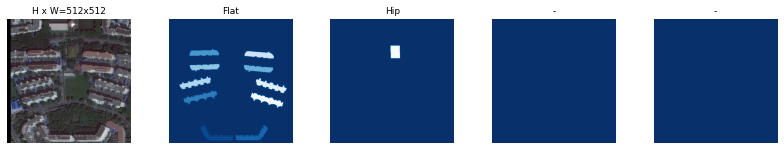

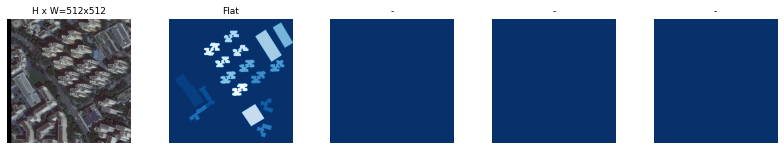

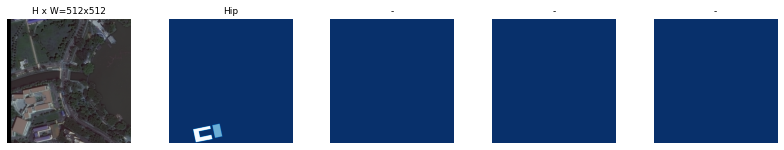

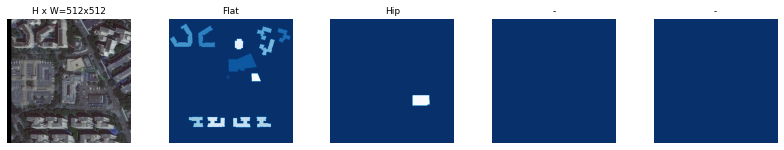

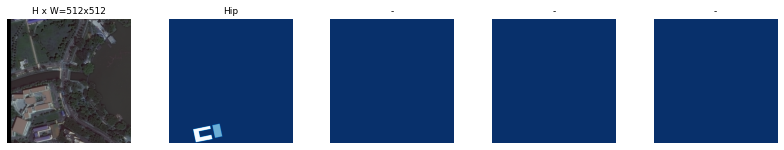

In [ ]:
dataset = dataset_val
image_ids = np.random.choice(dataset.image_ids, 5)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [ ]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

In [ ]:
# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
model.load_weights(WEIGHTS, by_name=True,
                    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
config.LEARNING_RATE

0.001

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./maskrcnn_config20200731T1649/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b    

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessi

Epoch 1/10
70/71 [============================>.] - ETA: 1s - loss: 2.1374 - rpn_class_loss: 0.2333 - rpn_bbox_loss: 0.4465 - mrcnn_class_loss: 0.3996 - mrcnn_bbox_loss: 0.5649 - mrcnn_mask_loss: 0.4930

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


71/71 [==============================] - 620s 9s/step - loss: 2.1242 - rpn_class_loss: 0.2306 - rpn_bbox_loss: 0.4429 - mrcnn_class_loss: 0.3997 - mrcnn_bbox_loss: 0.5609 - mrcnn_mask_loss: 0.4902 - val_loss: 1.9689 - val_rpn_class_loss: 0.1443 - val_rpn_bbox_loss: 0.4056 - val_mrcnn_class_loss: 0.4205 - val_mrcnn_bbox_loss: 0.5003 - val_mrcnn_mask_loss: 0.4981
Epoch 2/10
71/71 [==============================] - 85s 1s/step - loss: 1.4956 - rpn_class_loss: 0.1359 - rpn_bbox_loss: 0.3194 - mrcnn_class_loss: 0.3060 - mrcnn_bbox_loss: 0.3543 - mrcnn_mask_loss: 0.3800 - val_loss: 1.7386 - val_rpn_class_loss: 0.1206 - val_rpn_bbox_loss: 0.3347 - val_mrcnn_class_loss: 0.4160 - val_mrcnn_bbox_loss: 0.3976 - val_mrcnn_mask_loss: 0.4697
Epoch 3/10
71/71 [==============================] - 85s 1s/step - loss: 0.9990 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.1640 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.3000 - val_loss: 1.7071 - val_rpn_class_loss: 0.1441 - val_r

In [ ]:
class InferenceConfig(myMaskRCNNConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [ ]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir='./')

In [ ]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./maskrcnn_config20200731T1649/mask_rcnn_maskrcnn_config_0010.h5
Re-starting from epoch 10


In [ ]:
dataset_val.load_image(1).shape

(512, 512, 3)

In [ ]:
import skimage

image_paths = []
for filename in os.listdir(VALIDATION_ANNOTATION_IMAGE_DIR):
    if os.path.splitext(filename)[1].lower() in ['.tif', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(VALIDATION_ANNOTATION_IMAGE_DIR, filename))

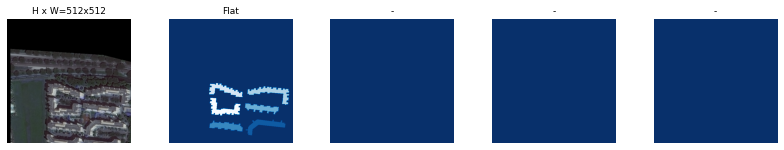

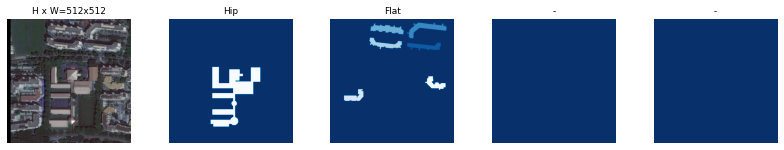

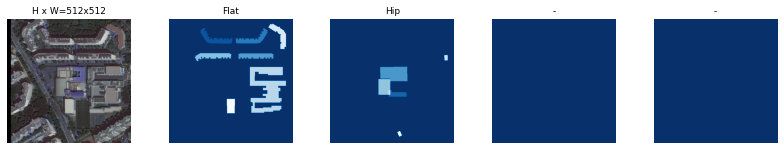

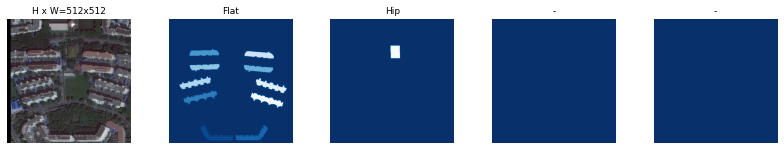

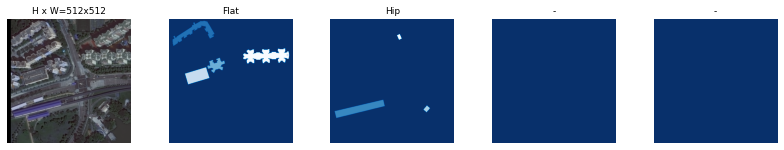

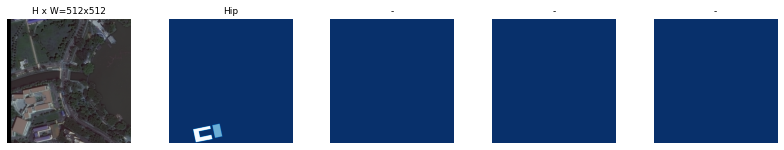

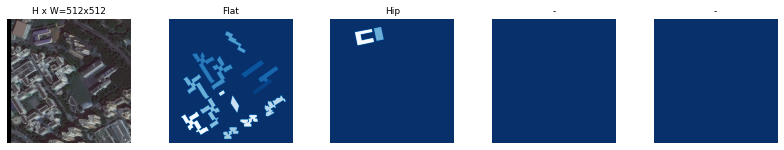

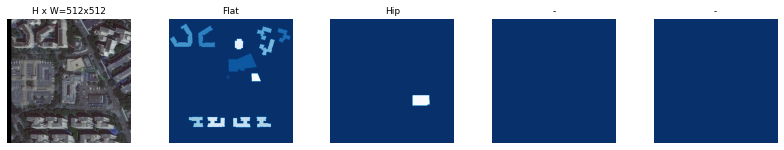

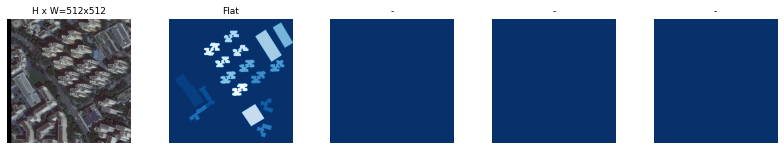

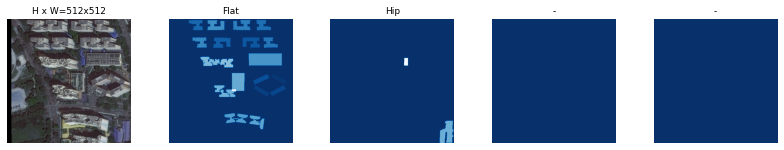

In [ ]:
# dataset = dataset_val
# # image_ids = np.random.choice(dataset.image_ids, 5)
# for image_id in range(10):
#     image = dataset.load_image(image_id)
#     mask, class_ids = dataset.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
groundtruth 0


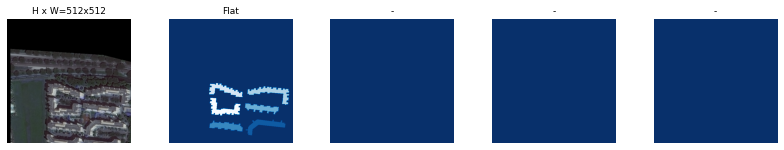

Predicted_results


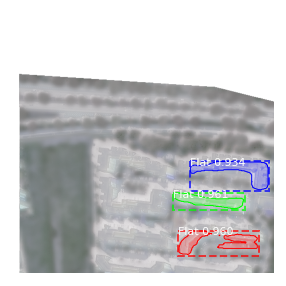

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
groundtruth 1


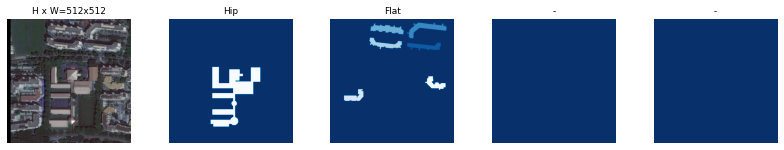

Predicted_results


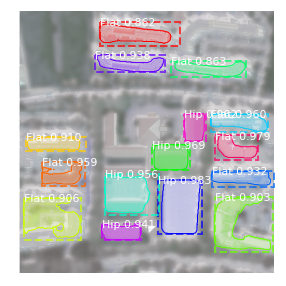

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
groundtruth 2


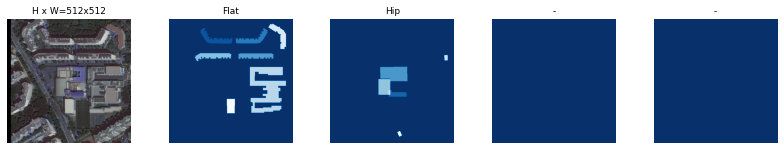

Predicted_results


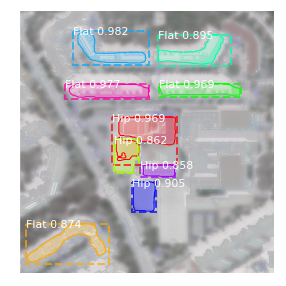

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
groundtruth 3


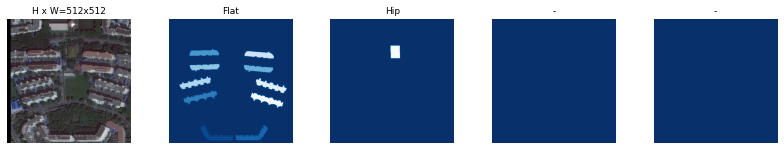

Predicted_results


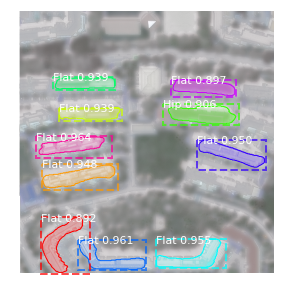

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  233.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  129.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
groundtruth 4


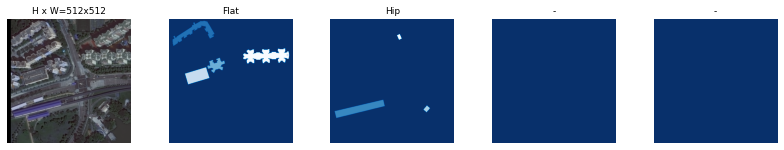

Predicted_results


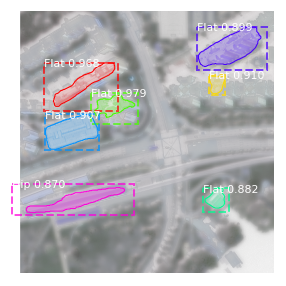

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  218.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  114.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
groundtruth 5


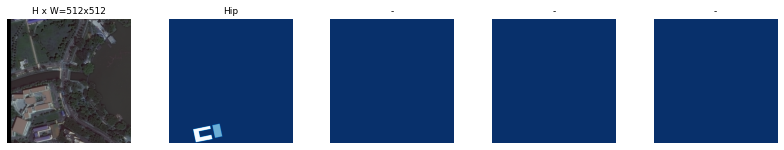

Predicted_results

*** No instances to display *** 



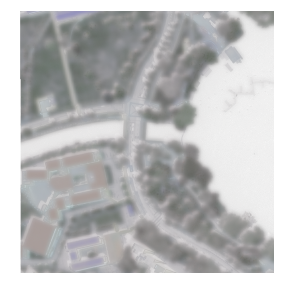

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  140.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
groundtruth 6


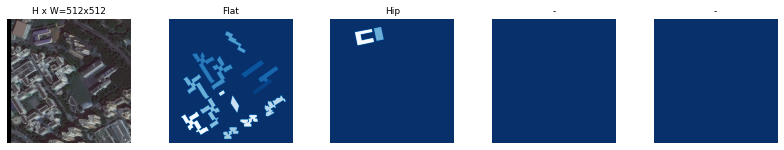

Predicted_results


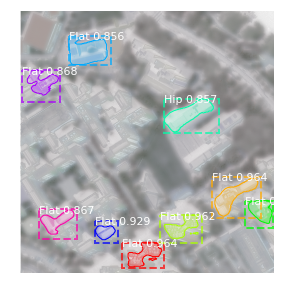

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
groundtruth 7


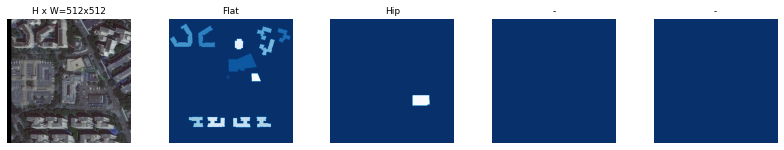

Predicted_results


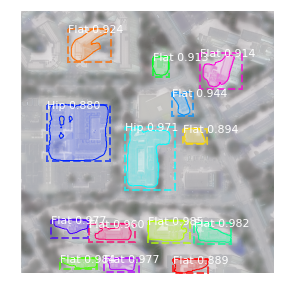

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
groundtruth 8


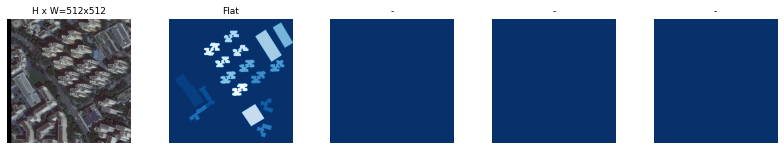

Predicted_results


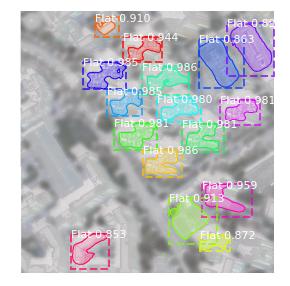

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
groundtruth 9


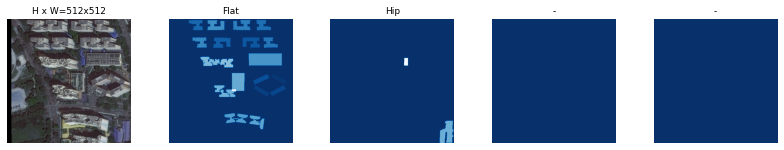

Predicted_results


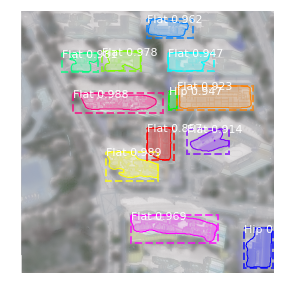

In [ ]:
for e,image_path in enumerate(image_paths):
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    if img_arr.shape[-1] == 4:
      img_arr = img_arr[..., :3]
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    print('groundtruth')
    mask, class_ids = dataset_val.load_mask(e)
    visualize.display_top_masks(img_arr, mask, class_ids, dataset_val.class_names)
    print('Predicted_results')
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

## CREATING CUSTOM JSON FILE

In [ ]:
annotations1 = json.load(open('/content/drive/My Drive/Omdena_solar_ai/coco_annotations.json'))

In [ ]:
for i in os.walk(TRAIN_ANNOTATION_IMAGE_DIR):
  listoffiles = i[-1]

In [ ]:
annotations1['categories']

[{'id': 1, 'name': 'Flat', 'supercategory': 'Rooftop'},
 {'id': 2, 'name': 'Hip', 'supercategory': 'Rooftop'},
 {'id': 3, 'name': 'Shed', 'supercategory': 'Rooftop'},
 {'id': 4, 'name': 'other', 'supercategory': 'other'}]

In [ ]:
image_dump = []
ids=[]
for file in listoffiles:
  for ann in annotations1['images']:
    if ann['file_name'] == file:
      image_dump.append(ann)
      ids.append(ann['id'])


In [ ]:
annot_dump = []
for id in ids:
  for ann in annotations1['annotations']:
    if ann['image_id']==id:
      annot_dump.append(ann)

In [ ]:
dictAnn = {'annotations': annot_dump}
dictImg = {'images': image_dump}
dictCategories={'categories': annotations1['categories']}

In [ ]:
COCOAnnotations = {**dictImg, **dictAnn,  **dictCategories} 

In [ ]:
def convert(o):
    if isinstance(o, np.int64): return int(o)  
    raise TypeError

import json
with open('/content/drive/My Drive/Omdena_solar_ai/train_annotations.json', 'w') as f:
    json.dump(COCOAnnotations, f, default=convert)